# 1. Load data

In [43]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
dir = os.getcwd()
data = pd.read_csv(dir + '/daily_treasury_rates.csv')
data['Date'] = pd.to_datetime(data['Date'])
# rename columns
data.columns = ['date', '1M','2M', '3M', '4M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']

In [45]:
# select columns from date to 2Y
#df = data[['date', '1M', '2M', '3M', '4M', '6M', '1Y', '2Y']].set_index('date')

<AxesSubplot:title={'center':'Yield Curve'}, xlabel='date'>

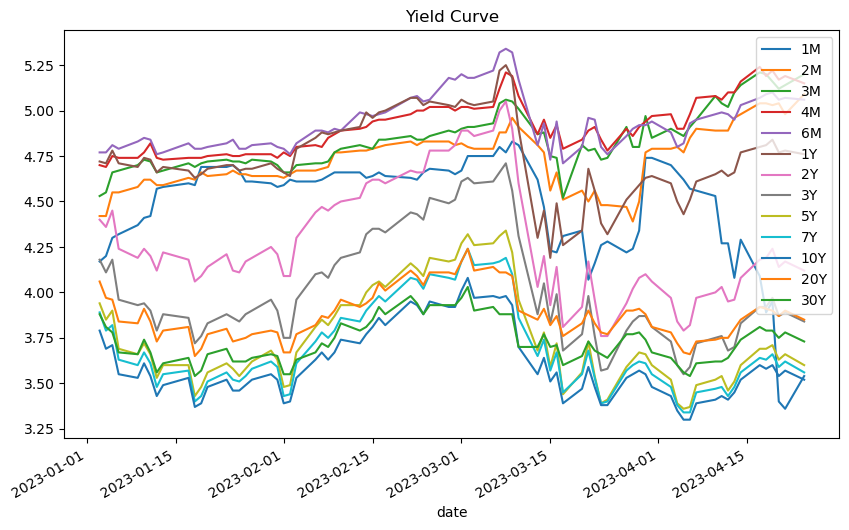

In [46]:
# plot time series for specific tenors
df = data[['date', '1M', '2M', '3M', '4M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']].set_index('date')
df.plot(figsize=(10, 6), title='Yield Curve', legend=True)

In [ ]:
#plot a dynamic change of curve shape over time, each row is a curve, x axis is the tenor, add a control to select the date range

# 2. Calculate forward rate based on current yield curce

In [50]:
yield_curve = data[['1M', '2M', '3M', '4M', '6M', '1Y', '2Y']].head(1).T.reset_index()
yield_curve.columns = ['Period','Rate']

In [51]:
yield_curve

,Period,Rate
0,1M,3.54
1,2M,5.09
2,3M,5.20
3,4M,5.15
4,6M,5.06
5,1Y,4.76
6,2Y,4.12


<AxesSubplot:title={'center':'Yield Curve'}, xlabel='Period'>

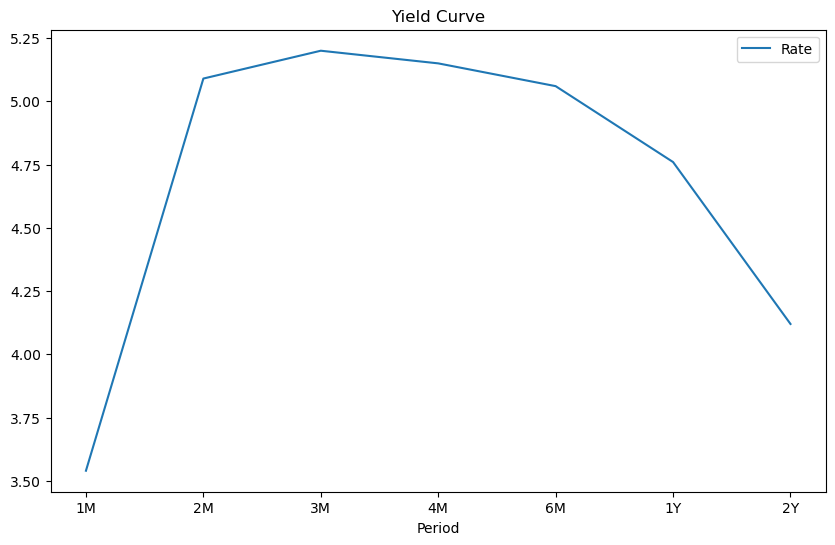

In [59]:
# plot the curve
yield_curve.plot(x='Period', y='Rate', figsize=(10, 6), title='Yield Curve', legend=True)

In [54]:
# calculate forward rates

def calculate_forward_rates(yield_curve):
    def price_from_yield(time, yield_rate):
        return 1 / (1 + yield_rate/100) ** time

    def forward_rate(price1, price2, time_diff):
        return ((price1 / price2) ** (1/time_diff) - 1) * 100

    yield_curve['Time (Years)'] = yield_curve['Period'].apply(lambda x: int(x[:-1]) / (12 if x[-1] == 'M' else 1))
    yield_curve['Price'] = yield_curve.apply(lambda x: price_from_yield(x['Time (Years)'], x['Rate']), axis=1)

    forward_rates = []
    for i in range(1, len(yield_curve)):
        price1 = yield_curve.at[i - 1, 'Price']
        price2 = yield_curve.at[i, 'Price']
        time_diff = yield_curve.at[i, 'Time (Years)'] - yield_curve.at[i - 1, 'Time (Years)']
        forward_rate_value = forward_rate(price1, price2, time_diff)
        forward_rates.append((yield_curve.at[i - 1, 'Period'], yield_curve.at[i, 'Period'], forward_rate_value))

    return forward_rates


# Example usage
forward_rates = calculate_forward_rates(yield_curve)

for rate in forward_rates:
    print(f'{rate[0]} to {rate[1]}: {rate[2]:.2f}%')



1M to 2M: 6.66%
2M to 3M: 5.42%
3M to 4M: 5.00%
4M to 6M: 4.88%
6M to 1Y: 4.46%
1Y to 2Y: 3.48%


In [87]:
#plot the forward curve as a function of time

forward_curve = pd.DataFrame(forward_rates, columns=['Period 1', 'Period 2', 'Rate'])
#add (ON, 1M) to the first row
forward_curve.loc[-1] = ['ON', '1M', 3.54]
forward_curve.index = forward_curve.index + 1
forward_curve = forward_curve.sort_index()


In [102]:
# concat the two dataframes
yield_curve['Type'] = 'Yield'
forward_curve['Type'] = 'Forward'
curve = forward_curve.join(yield_curve, how='right', lsuffix='_forward', rsuffix='_yield')
curve = curve[['Period 1','Period 2', 'Rate_yield','Rate_forward',"forward_change"]]

#get forward rate change
curve['forward_change'] = curve['Rate_forward'].diff().div(-300)
# move up one row for forward change 
curve['forward_change'] = curve['forward_change'].shift(-1)


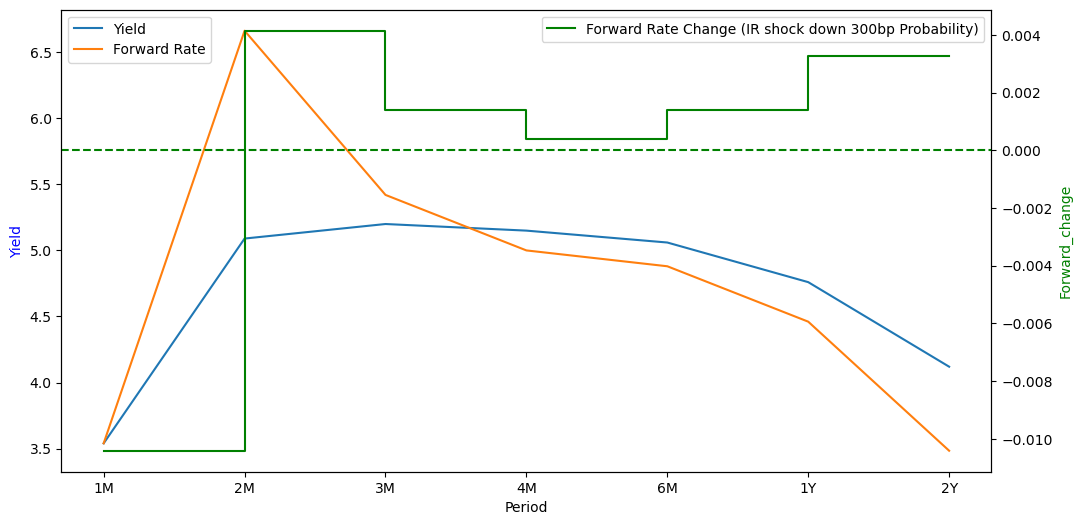

In [125]:
# plot the two curve in one plot
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(curve['Period 2'], curve['Rate_yield'])
ax1.plot(curve['Period 2'], curve['Rate_forward'])
ax2.plot(curve['Period 2'], curve['forward_change'].interpolate(), drawstyle='steps-post', color='g') # legend='Forward Rate Change (IR shock down 300bp Probability)'
ax1.set_xlabel('Period')
ax1.set_ylabel('Yield', color='b')
ax2.set_ylabel('Forward_change', color='g')
#add a dash line at y=0
ax2.axhline(y=0, color='g', linestyle='--')

# add legends
ax1.legend(['Yield', 'Forward Rate'], loc='upper left')
ax2.legend(['Forward Rate Change (IR shock down 300bp Probability)'], loc='upper right')

plt.show()

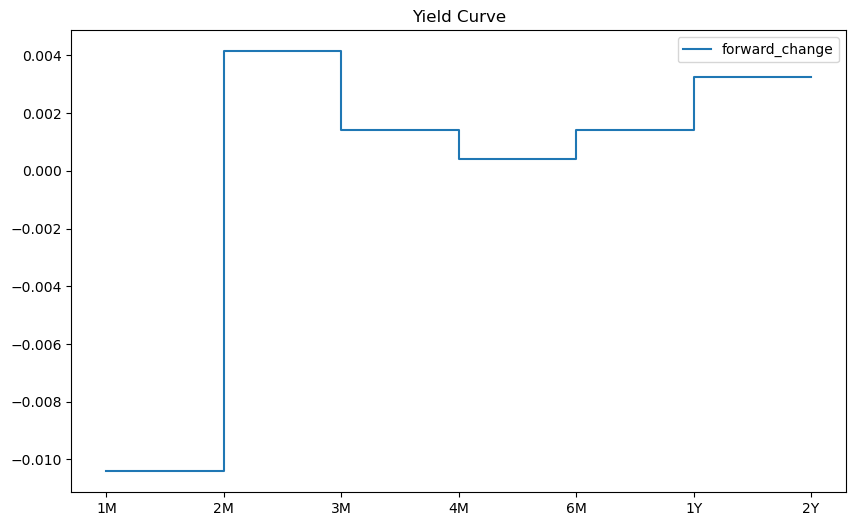

<AxesSubplot:title={'center':'Yield Curve'}, xlabel='Period 2'>

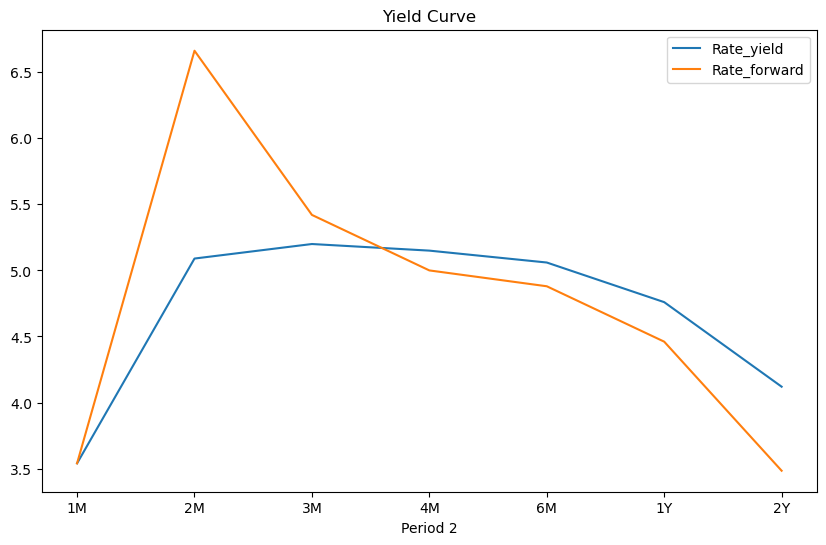

In [111]:
# step plot the forward change, x axis is period 2
curve['forward_change'].interpolate().plot(figsize=(10, 6), title='Yield Curve', legend=True, drawstyle='steps-post')

# set x axis to be period 2
plt.xticks(np.arange(len(curve['Period 2'])), curve['Period 2'])
plt.show()

# plot curve at two axis
curve.plot(x='Period 2', y=['Rate_yield','Rate_forward'], figsize=(10, 6), title='Yield Curve', legend=True)
